In [42]:
import sys
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from autogluon.vision import ImageDataset

## Get verified labels for subset of data

In [46]:
!ls /Data/Food-101N_release/meta

classes.txt		classes_heldout_50.tsv	verified_train.tsv
classes_heldout_10.tsv	classes_heldout_70.tsv	verified_val.tsv
classes_heldout_30.tsv	imagelist.tsv


In [15]:
path_verified_train = "/Data/Food-101N_release/meta/verified_train.tsv"

df_verified_train = pd.read_csv(path_verified_train, sep='\t')

df_verified_train.head(3)

,class_name/key,verification_label
0,apple_pie/7a6a67e05daf10b106ccd592baa0eadd.jpg,1
1,apple_pie/ddc6e9a24fd9333a9c30ef5659e17409.jpg,1
2,apple_pie/93fc8efb8dd49e58ebaf62852bd7dac0.jpg,1


In [10]:
df_verified_train.shape

(52868, 2)

In [5]:
df_verified_train.verification_label.mean()

0.815635166830597

## Copy file of verified labels

In [4]:
!cp /Data/Food-101N_release/meta/verified_train.tsv .

## Check if all images in the "verified_train.tsv" file is in the dataset

In [7]:
# original data deduped
DATA_PATH = "/Data/Food-101N_release/"

# read data from root folder
train_dataset, _, _ = \
    ImageDataset.from_folders(
        root=DATA_PATH,
    )

train_dataset["class_name/key"] = train_dataset.image.map(lambda f: "/".join(Path(f).parts[-2:]))

train_dataset.head(3)

,image,label,class_name/key
0,/Data/Food-101N_release/train/apple_pie/000036...,0,apple_pie/000036ee3613531a745a05052e6a3ed7.jpg
1,/Data/Food-101N_release/train/apple_pie/00168d...,0,apple_pie/00168d0c6df7fb7b7b786a22c2ff2f4a.jpg
2,/Data/Food-101N_release/train/apple_pie/001960...,0,apple_pie/00196077deceacae8f88408b7e0cc216.jpg


In [8]:
# there's one image missing!

A = train_dataset["class_name/key"].values.tolist()
B = df_verified_train["class_name/key"].values.tolist()

set(B) - set(A).intersection(set(B))

{'hot_and_sour_soup/a49e6fb26e356c6c41a37b5c18176355.jpg'}

## Read pickle files from cross-validation

In [6]:
# utils functions below (can consider moving these to separate utils.py file)

def load_pickle(pickle_file_name, verbose=1):
    """Load pickle file"""

    if verbose:
        print(f"Loading {pickle_file_name}")

    with open(pickle_file_name, 'rb') as handle:
        out = pickle.load(handle)
        
    return out

# get the original label from file path (aka "true labels" y)
get_orig_label_idx_from_file_path = np.vectorize(lambda f: label_name_to_idx_map[Path(f).parts[-2]])

In [11]:
num_cv_folds = 5 # number K in stratified K-folds cross-validation
verbose = 0

models = [
    # "resnet18", 
    # "resnet50d",
    # "efficientnet_b1",
    "twins_pcpvt_base",
    # "swin_base_patch4_window7_224"
]

results_list = []

for model in models:

    pred_probs = []
    labels = []
    images = []
    
    for split_num in range(num_cv_folds):

        out_subfolder = f"./food-101n_cv_{model}/split_{split_num}/"
        
        # pickle file name to read
        get_pickle_file_name = (
            lambda object_name: f"{out_subfolder}_{object_name}_split_{split_num}"
        )

        # NOTE: the "test_" prefix in the pickle name correspond to the "test" split during cross-validation.
        pred_probs_split = load_pickle(get_pickle_file_name("test_pred_probs"), verbose=verbose)
        labels_split = load_pickle(get_pickle_file_name("test_labels"), verbose=verbose)
        images_split = load_pickle(get_pickle_file_name("test_image_files"), verbose=verbose)
        indices_split = load_pickle(get_pickle_file_name("test_indices"), verbose=verbose)

        # append to list so we can combine data from all the splits
        pred_probs.append(pred_probs_split)
        labels.append(labels_split)
        images.append(images_split)    

    # convert list to array
    pred_probs = np.vstack(pred_probs)
    labels = np.hstack(labels) # remember that this is the noisy labels
    images = np.hstack(images)
    
    # get the true labels
    
    # sanity check: accuracy of noisy labels vs true labels
    # print(f"Accuracy of noisy labels vs true labels: {(labels == true_labels).mean()}")
    
    # save to Numpy files
    numpy_out_folder = f"./food-101n_cv_{model}/"
    
    print(f"Saving to numpy files in this folder: {numpy_out_folder}")
    print()
    
    np.save(numpy_out_folder + "pred_probs", pred_probs)
    np.save(numpy_out_folder + "noisy_labels", labels)
    np.save(numpy_out_folder + "images", images)

Saving to numpy files in this folder: ./food-101n_cv_twins_pcpvt_base/



## Misc: Read numpy file

In [16]:
model = "swin_base_patch4_window7_224"
numpy_out_folder = f"./food-101n_cv_{model}/"

pred_probs = np.load(numpy_out_folder + "pred_probs.npy")
labels = np.load(numpy_out_folder + "noisy_labels.npy")
images = np.load(numpy_out_folder + "images.npy", allow_pickle=True)

In [11]:
pred_probs.shape

(310009, 101)

In [17]:
# instantiate DataFrame with all training data
df_image_paths = pd.DataFrame({
    "class_name/key": pd.Series(images).map(lambda f: "/".join(Path(f).parts[-2:]))
})

# join to append verification_label column
df_image_paths_w_verified = df_image_paths.merge(df_verified_train, on="class_name/key", how="left")

# subset of data with verified labels
verified_subset_mask = ~df_image_paths_w_verified.verification_label.isnull().values

df_image_paths_w_verified.head()

,class_name/key,verification_label
0,apple_pie/000036ee3613531a745a05052e6a3ed7.jpg,NaN
1,apple_pie/00168d0c6df7fb7b7b786a22c2ff2f4a.jpg,1.0
2,apple_pie/00196077deceacae8f88408b7e0cc216.jpg,NaN
3,apple_pie/003ba1197bb2ffca00036bbd1bfae139.jpg,NaN
4,apple_pie/00861f70adfd37898114b83ff16978d0.jpg,1.0


In [18]:
# filter on verified subset

pred_probs_subset = pred_probs[verified_subset_mask]
labels_subset = labels[verified_subset_mask]
images_subset = images[verified_subset_mask]

# label error boolean mask for subset of verified labels
label_errors_target_subset = df_image_paths_w_verified["verification_label"].values[verified_subset_mask] == 0

In [83]:
df_class_overlap = cleanlab.dataset.find_overlapping_classes(labels=labels_subset, pred_probs=pred_probs_subset, class_names=train_dataset.classes)

In [84]:
df_class_overlap.head()

,Class Name A,Class Name B,Class Index A,Class Index B,Num Overlapping Examples,Joint Probability
0,filet_mignon,steak,37,93,176,0.003329
1,chocolate_cake,chocolate_mousse,21,22,119,0.002251
2,dumplings,gyoza,32,52,116,0.002194
3,sashimi,sushi,86,95,111,0.002100
4,falafel,hummus,36,57,111,0.002100


In [35]:
label_errors_target_subset.mean()


0.18434940511093878

In [79]:
label_errors_target_subset.sum()

9746

In [19]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve
import cleanlab
from matplotlib import pyplot as plt
from PIL import Image
import math

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


method = "confidence_weighted_entropy"
adjust_pred_probs = False

# compute scores
label_quality_scores = cleanlab.rank.get_label_quality_scores(labels=labels_subset, pred_probs=pred_probs_subset, method=method, adjust_pred_probs=adjust_pred_probs)

# try entropy as label quality scoring method
# label_quality_scores = 1 - cleanlab.internal.label_quality_utils.get_normalized_entropy(pred_probs=pred_probs_subset)


# compute accuracy of detecting label errors
auroc = roc_auc_score(label_errors_target_subset, 1 - label_quality_scores)

auroc

0.9234057097777817

In [20]:
df_temp = pd.DataFrame({
    "images_subset": images_subset,
    "label_quality_scores": label_quality_scores,
    "label_errors_target_subset": label_errors_target_subset
})

df_temp.sort_values(by="label_quality_scores").head()

,images_subset,label_quality_scores,label_errors_target_subset
5946,/Data/Food-101N_release/train/huevos_rancheros/1c706a420e6bbbb0a467f65403fca082.jpg,0.000692,True
33138,/Data/Food-101N_release/train/caprese_salad/cd026fc9d72ecc7d7492e3a1ef42662d.jpg,0.000844,True
40204,/Data/Food-101N_release/train/ramen/99985b26ea6407bdad6085b01e6480c6.jpg,0.000902,False
22537,/Data/Food-101N_release/train/carrot_cake/8a772744f3288c24c7fef5541a584ca4.jpg,0.000943,True
28923,/Data/Food-101N_release/train/peking_duck/80290c432cd15200e7f27470ee4fbd34.jpg,0.001648,True


In [21]:
df_verified_train[df_verified_train["class_name/key"] == "ramen/99985b26ea6407bdad6085b01e6480c6.jpg"]

,class_name/key,verification_label
42907,ramen/99985b26ea6407bdad6085b01e6480c6.jpg,1


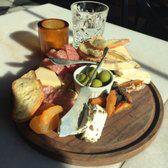

In [22]:
f = "/Data/Food-101N_release/train/ramen/99985b26ea6407bdad6085b01e6480c6.jpg"

with Image.open(f) as im:
    im.show()

/tmp/ipykernel_9473/737142500.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  title_color = ("b", "r")[error]


Text(0.5, 0.98, 'Top 20 Images Ordered by Confidence Weighted Entropy \n Model: Swin Transformer')

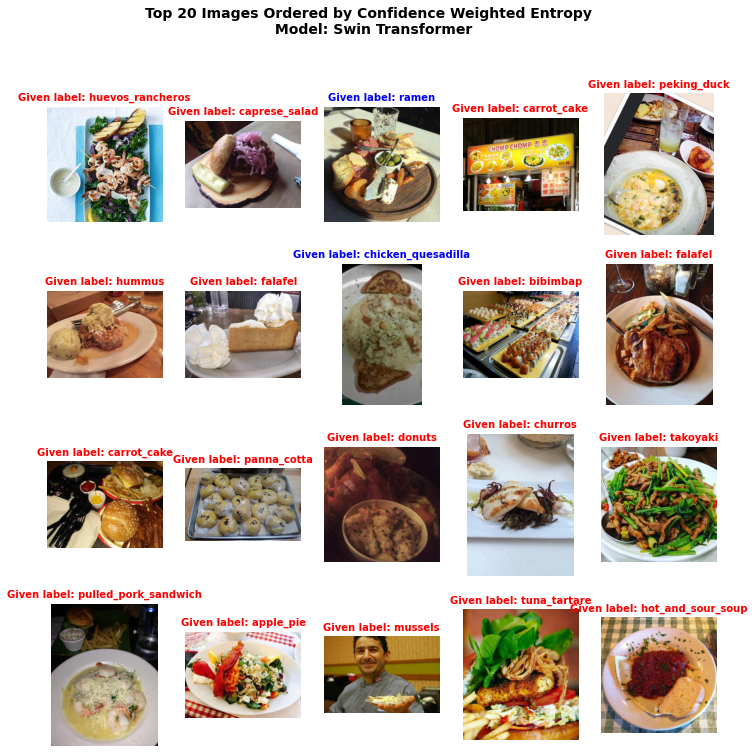

In [24]:
TOP_K = 20
GRID_SAVE_PATH = f"grid_temp.png"



top_k = np.argsort(label_quality_scores)[:TOP_K]

# list of image paths
# e.g. "../data/train/i/foo.png"
image_paths = images_subset[top_k]
image_labels = labels_subset[top_k]
image_errors = label_errors_target_subset[top_k]

# count of images
image_cnt = len(image_paths)



# configure grid
fig_size = 12  # resolution; 1 = 100px
num_cols = 5  # set the number of desired columns
num_rows = math.ceil(
    image_cnt / num_cols
)  # number of rows will be automatically set
fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_size, fig_size))

# loop through each image
for idx, image_path in enumerate(image_paths):

    # given label
    given_label = Path(image_path).parts[-2]

    # set the position of the image on the grid
    row_pos = idx // num_cols
    col_pos = idx % num_cols

    # read image
    plt_image = plt.imread(image_path)

    # show image
    axes[row_pos, col_pos].axis("off")
    #     axes[row_pos, col_pos].set_facecolor('xkcd:salmon')

    error = image_errors[idx]
    title_color = ("b", "r")[error]

    axes[row_pos, col_pos].set_title(
        f"Given label: {given_label}", size=10, fontweight="bold", color=title_color
    )
    axes[row_pos, col_pos].imshow(plt_image)

plt.suptitle(f"Top 20 Images Ordered by Confidence Weighted Entropy \n Model: Swin Transformer", size=14, fontweight="bold")
# plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
# plt.savefig(GRID_SAVE_PATH)

In [35]:
TOP_K = 20
GRID_SAVE_PATH = f"grid_temp.png"



top_k = np.argsort(label_quality_scores)[:TOP_K]

# list of image paths
# e.g. "../data/train/i/foo.png"
image_paths = images_subset[top_k]
image_labels = labels_subset[top_k]
image_errors = label_errors_target_subset[top_k]

# configure grid
fig_size = 13  # resolution; 1 = 100px
num_cols = 5  # set the number of desired columns


def viz_top_k_image_label_issues(
    image_paths,
    image_labels,
    image_errors,
    title="Top K Images",
    fig_size=12,
    num_cols=5,
    save_path="grid_temp.png"
):
    
    # count of images
    image_cnt = len(image_paths)

    # create plot
    num_rows = math.ceil(
        image_cnt / num_cols
    )  # number of rows will be automatically set
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_size, fig_size))

    # loop through each image
    for idx, image_path in enumerate(image_paths):

        # given label
        given_label = Path(image_path).parts[-2]

        # set the position of the image on the grid
        row_pos = idx // num_cols
        col_pos = idx % num_cols

        # read image
        plt_image = plt.imread(image_path)

        # show image
        axes[row_pos, col_pos].axis("off")
        #     axes[row_pos, col_pos].set_facecolor('xkcd:salmon')

        error = image_errors[idx]
        title_color = ("b", "r")[error]

        axes[row_pos, col_pos].set_title(
            f"Given label: {given_label}", size=10, fontweight="bold", color=title_color
        )
        axes[row_pos, col_pos].imshow(plt_image)

    plt.suptitle(title, size=14, fontweight="bold")
    # plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
    # plt.savefig(save_path)

/tmp/ipykernel_9473/2894807937.py:56: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  title_color = ("b", "r")[error]


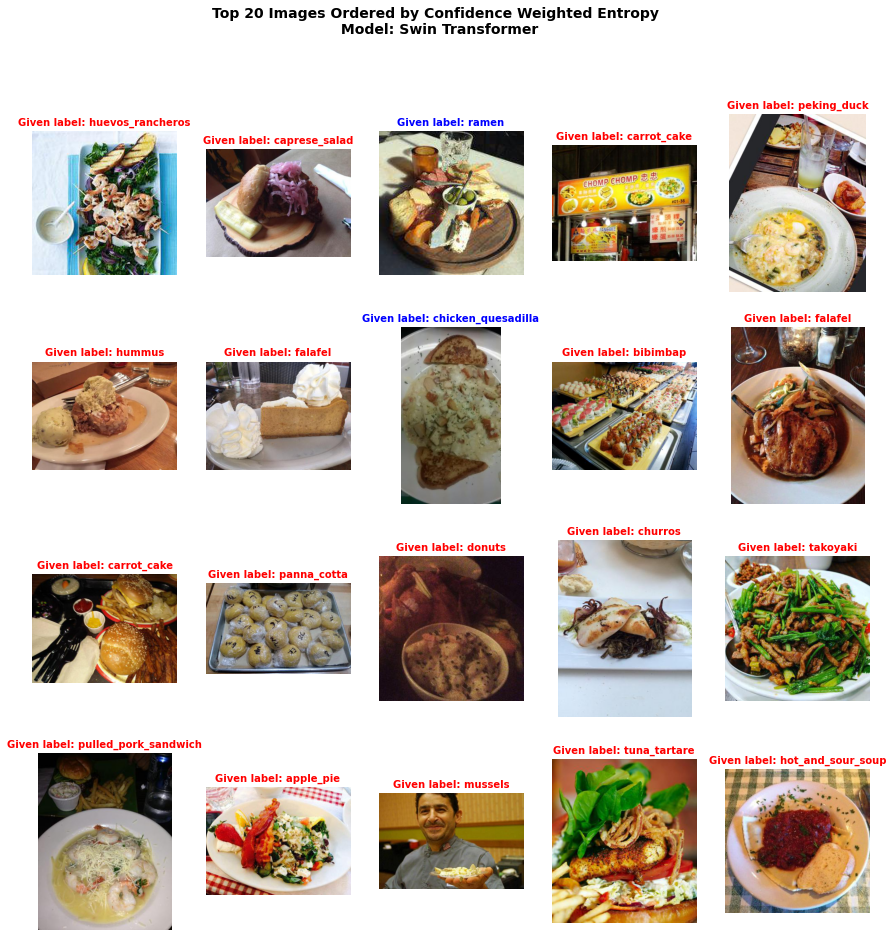

In [41]:
title = f"Top 20 Images Ordered by Confidence Weighted Entropy \n Model: Swin Transformer"

viz_top_k_image_label_issues(image_paths=image_paths, image_labels=image_labels, image_errors=image_errors, title=title, fig_size=15)

In [74]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# pointer
true_label_issues = label_errors_target_subset

# code below adapted from v2.0.0 docs
# https://colab.research.google.com/github/cleanlab/cleanlab-docs/blob/master/v2.0.0/tutorials/indepth_overview.ipynb#scrollTo=kCfdx2gOLmXS

# Find label issues with different filter_by options
filter_by_list = [
    "prune_by_noise_rate",
    "prune_by_class",
    "both",
    "confident_learning",
    "predicted_neq_given",
]

results = []

for filter_by in filter_by_list:

    # Find label issues
    label_issues = cleanlab.filter.find_label_issues(
        labels=labels_subset, 
        pred_probs=pred_probs_subset, 
        filter_by=filter_by
    )
    
    precision = precision_score(true_label_issues, label_issues)
    recall = recall_score(true_label_issues, label_issues)
    f1 = f1_score(true_label_issues, label_issues)
    acc = accuracy_score(true_label_issues, label_issues)
    
    result = {
        "filter_by algorithm": filter_by,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": acc,
        "num_est_label_issues": label_issues.sum()
    }
    
    results.append(result)

# summary of results
# pd.DataFrame(results).sort_values(by='f1', ascending=False)

pd.DataFrame(results)

,filter_by algorithm,precision,recall,f1,accuracy,num_est_label_issues
0,prune_by_noise_rate,0.550756,0.340140,0.420552,0.827208,6019
1,prune_by_class,0.754151,0.484712,0.590131,0.875877,6264
2,both,0.709610,0.242458,0.361426,0.842056,3330
3,confident_learning,0.526421,0.215678,0.305990,0.819642,3993
4,predicted_neq_given,0.551201,0.816848,0.658233,0.843626,14443
